# Ανάλυση Συναισθημάτων (Sentiment Analysis)
* Μέλλιος Θοδωρής-Μάριος - 1115201500093
* Σταυρακάκης Νικόλαος - 1115201500149

In [1]:
#imports
import time
start_time = time.time()

import collections
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud

## Προεπεξεργασία και καθάρισμα δεδομένων
Αρχικά, καθαρίζουμε τα *train2017.tsv* και *test2017.tsv* και τα αποθηκεύουμε ως * *_cleaned.tsv*.
Πιο συγκεκριμένα:
* κανουμε πεζά τα tweets
* αφαιρούμε σύμβουλα, όπως Hashtags, κτλπ
* αφαιρούμε τα emoji και τους άγνωστους-μη αγγλικούς χαρακτήρες
* διαγράφουμε εντελώς τα mentions(@) και τα url's
* αφαιρούμε τα stop-words
* εφαρμόζουμε το stemming στις εναπομείναντες λέξεις

In [2]:
def stemming(w):
    ps = PorterStemmer()
    return ps.stem(w)

def cleaning(s, stem_flag=1):
    s = re.sub(r"(?:\@|http)\S+", "", s)
    s = s.lower()
    s = s.replace("\\u002c", ',')   # \u002c : ,
    s = s.replace("\\u2019", '')    # \u2019 : '
    s = s.replace("&amp;", '&')     # &amp; : &
    for char in string.punctuation:
        s = s.replace(char, ' ')
    cleared_string = ""
    word_tokens = word_tokenize(s) 
    for word in word_tokens:
        if word not in stopwords.words('english') and all(ord(char) < 128 for char in word):
                if stem_flag:
                    cleared_string += stemming(word) #not for wordclouds
                else:
                    cleared_string += word
                cleared_string += ' '
    return cleared_string

print("Cleaning train2017.tsv...")
with open('../twitter_data/train2017.tsv') as input_file, open('../twitter_data/train2017_cleaned.tsv', 'w') as output_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        cleaned_tweet = cleaning(row[3])
        output_file.write(row[0] + '\t' + row[1] + '\t' + row[2] + '\t' + cleaned_tweet + '\n')
print("Done. Saved as train2017_cleaned.tsv\n")

print("Cleaning test2017.tsv...")
with open('../twitter_data/test2017.tsv') as input_file, open('../twitter_data/test2017_cleaned.tsv', 'w') as output_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        cleaned_tweet = cleaning(row[3])
        output_file.write(row[0] + '\t' + row[1] + '\t' + row[2] + '\t' + cleaned_tweet + '\n')
print("Done. Saved as test2017_cleaned.tsv\n")

Cleaning train2017.tsv...
Done. Saved as train2017_cleaned.tsv

Cleaning test2017.tsv...
Done. Saved as test2017_cleaned.tsv



## Ανάλυση των δεδομένων
Παρουσιάζουμε κάποιες ενδιαφέρουσες και χρήσιμες πληροφορίες που συγκεντρώσαμε, αναλύοντας τα tweets από το *train2017_cleaned.tsv.

In [3]:
all_tweets = []
pos_tweets = []
neg_tweets = []
neu_tweets = []
labels = []
with open('../twitter_data/train2017.tsv') as input_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        cleaned_tweet = cleaning(row[3], 0)
        all_tweets.append(cleaned_tweet)
        if row[2] == "positive":
            pos_tweets.append(cleaned_tweet)
        elif row[2] == "negative":
            neg_tweets.append(cleaned_tweet)
        else: #if neutral
            neu_tweets.append(cleaned_tweet)

### Wordclouds

Δημιουργούμε κάποια WordClouds με:
* τις συνηθέστερες λέξεις σε ολόκληρο το σύνολο δεδομένων
* τις συνηθέστερες λέξεις στο σύνολο δεδομένων για τα αρνητικά, τα θετικά και τα ουδέτερα tweets

Generating WordClouds...


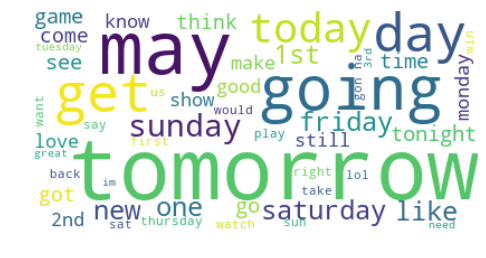

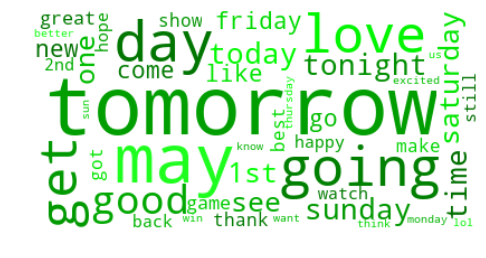

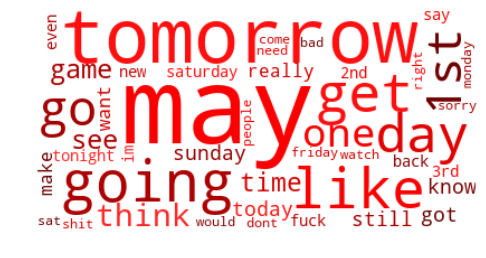

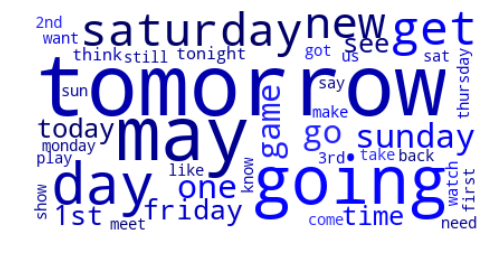

Done.


In [4]:
def red_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    hue = 360.0
    h = int(hue)
    s = int(100.0)
    l = int(40.0 * float(random.uniform(0.5, 1.5)))
    return "hsl({}, {}%, {}%)".format(h, s, l)

def green_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    hue = 120.0
    h = int(hue)
    s = int(100.0)
    l = int(40.0 * float(random.uniform(0.5, 1.5)))
    return "hsl({}, {}%, {}%)".format(h, s, l)

def blue_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    hue = 240.0
    h = int(hue)
    s = int(100.0)
    l = int(40.0 * float(random.uniform(0.5, 1.5)))
    return "hsl({}, {}%, {}%)".format(h, s, l)

def generate_wc(x, name, main_color=None):
    if(main_color=="green"):
        curr_wc = WordCloud( background_color = 'white', stopwords = stopwords.words('english'), min_font_size = 10, color_func=green_color_func).generate(x)
    elif(main_color=="red"):
        curr_wc = WordCloud( background_color = 'white', stopwords = stopwords.words('english'), min_font_size = 10, color_func=red_color_func).generate(x)
    elif(main_color=="blue"):
        curr_wc = WordCloud( background_color = 'white', stopwords = stopwords.words('english'), min_font_size = 10, color_func=blue_color_func).generate(x)
    else:
        curr_wc = WordCloud( background_color = 'white', stopwords = stopwords.words('english'), min_font_size = 10).generate(x)
    plt.figure(figsize = [8, 8])
    plt.imshow(curr_wc, interpolation="bilinear")
    plt.axis("off")
    name = 'wordclouds/' + name + '.png'
    plt.savefig(name, format="png")
    plt.show()

print("Generating WordClouds...")
generate_wc((" ").join(all_tweets), "all_tweets_wordcloud")
generate_wc((" ").join(pos_tweets), "pos_tweets_wordcloud", "green")
generate_wc((" ").join(neg_tweets), "neg_tweets_wordcloud", "red")
generate_wc((" ").join(neu_tweets), "neu_tweets_wordcloud", "blue")
print("Done.")
#print("Done. Saved in scr/wordclouds/.\n")    

### Graphs

Δημιουργούμε κάποια γραφήματα με:
* τις θετικές/αρνητικές λέξεις με τις περισσότερες εμφανίσεις στα θετικά/αρνητικά tweets
* τα mentions στα tweets όπου εμφανίζονται πιο συχνά για θετικό/αρνητικό λόγο

Generating Graphs...
Done.



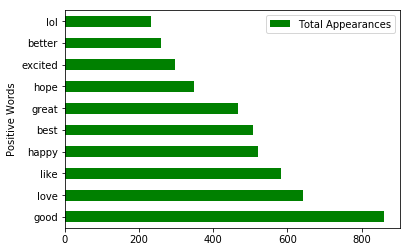

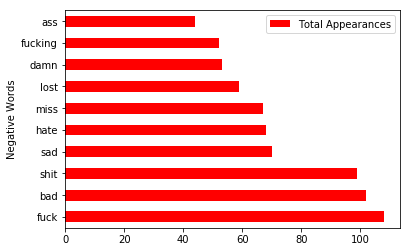

In [5]:
print("Generating Graphs...")

def generate_graph(curr_list, curr_type):
    wordcount = {}
    for tweet in curr_list:
        tweet_tokens = word_tokenize(tweet)
        for word in tweet_tokens:
            with open('../lexica/affin/affin.txt') as input_file:
                reader = csv.reader(input_file, delimiter='\t')
                for row in reader:
                    if(row[0][0]>word[0]):
                        break
                    if(row[0] == word):
                        if(curr_type == "positive"):
                            if(int(row[1])>=2):
                                if word not in wordcount:
                                    wordcount[word] = 1
                                else:
                                    wordcount[word] += 1
                        else: #elif(curr_type = "negative"):
                            if(int(row[1])<=-2):
                                if word not in wordcount:
                                    wordcount[word] = 1
                                else:
                                    wordcount[word] += 1
                        break
    return wordcount

word_counter = collections.Counter(generate_graph(pos_tweets, "positive"))
lst = word_counter.most_common(10)
df = pd.DataFrame(lst, columns = ['Positive Words', 'Total Appearances'])
fig = df.plot.barh(x='Positive Words',y='Total Appearances', color='green')

word_counter = collections.Counter(generate_graph(neg_tweets, "negative"))
lst = word_counter.most_common(10)
df = pd.DataFrame(lst, columns = ['Negative Words', 'Total Appearances'])
df.plot.barh(x='Negative Words',y='Total Appearances', color='red')

print("Done.\n") 

Generating Graphs...
Done.



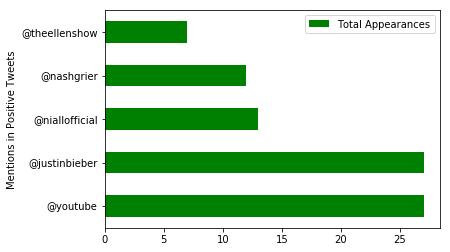

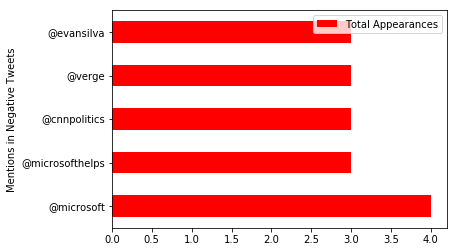

In [6]:
print("Generating Graphs...")

mentions_list = {}
with open('../twitter_data/train2017.tsv') as input_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        row[3] = row[3].replace('@ ', '@-')
        flag = 0
        word_tokens = word_tokenize(row[3]) 
        for word in word_tokens:
            word = word.lower()
            if flag:
                if word.isalpha():
                    word = "@"+word
                    if(word not in mentions_list):
                        if(row[2]=="positive"):
                            mentions_list[word] = 1
                        elif(row[2]=="negative"):
                            mentions_list[word] = -1
                    else:
                        if(row[2]=="positive"):
                            mentions_list[word] += 1
                        elif(row[2]=="negative"):
                            mentions_list[word] -= 1
                flag = 0
            elif(word=="@"):
                flag = 1

best_mentions_dict = {}
worst_mentions_dict = {}
for key in mentions_list:
    if(mentions_list[key]>0):
        best_mentions_dict[key] = mentions_list[key]
    if(mentions_list[key]<0):
        worst_mentions_dict[key] = mentions_list[key]*(-1)
                
best_mentions = collections.Counter(best_mentions_dict).most_common()
worst_mentions = collections.Counter(worst_mentions_dict).most_common()

num_of_items = 5

df = pd.DataFrame(best_mentions[:num_of_items], columns = ['Mentions in Positive Tweets', 'Total Appearances'])
df.plot.barh(x='Mentions in Positive Tweets',y='Total Appearances', color='green')

df = pd.DataFrame(worst_mentions[:num_of_items], columns = ['Mentions in Negative Tweets', 'Total Appearances'])
df.plot.barh(x='Mentions in Negative Tweets',y='Total Appearances', color='red')

print("Done.\n") 

## Vectorization - εξαγωγή χαρακτηριστικών
Εξάγουμε και ετοιμάζουμε τα χαρακτηριστικά(features) για κάθε tweet χρησιμοποιώντας:
* Bag-of-words
* Tf_idf
* word embeddings

In [7]:
train_tweets = []
labels = []
with open('../twitter_data/train2017_cleaned.tsv') as input_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        labels.append(row[2])
        train_tweets.append(row[3])

test_tweets = []
with open('../twitter_data/test2017_cleaned.tsv') as input_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        test_tweets.append(row[3])

### Bag-of-words

In [8]:
#for train2017_cleaned.tsv
bow_vectorizer = CountVectorizer()
bow_xtrain = bow_vectorizer.fit_transform(train_tweets)    
#bow_xtrain = bow_vectorizer.fit_transform(train_tweets[:3])    
#print(bow_xtrain.shape)
#print(vectorizer.get_feature_names())
#print(bow_xtrain.toarray())
output = open('pickles/bow_xtrain.pkl', 'wb')
pickle.dump(bow_xtrain, output)
output.close()
print("pickles/bow_xtrain.pkl saved successfully.")

#for test2017_cleaned.tsv
bow_vectorizer = CountVectorizer()
bow_xtest = bow_vectorizer.fit_transform(test_tweets)    
#bow_xtest = bow_vectorizer.fit_transform(test_tweets[:3])    
#print(bow_xtest.shape)
#print(vectorizer.get_feature_names())
#print(bow_xtest.toarray())
output = open('pickles/bow_xtest.pkl', 'wb')
pickle.dump(bow_xtest, output)
output.close()
print("pickles/bow_xtest.pkl saved successfully.")

pickles/bow_xtrain.pkl saved successfully.
pickles/bow_xtest.pkl saved successfully.


### Tf_idf

In [9]:
#for train2017_cleaned.tsv
tfidf_vectorizer = TfidfVectorizer()
tfdif_xtrain = tfidf_vectorizer.fit_transform(train_tweets)
#print(tfdif_xtrain.shape)
output = open('pickles/tfdif_xtrain.pkl', 'wb')
pickle.dump(tfdif_xtrain, output)
output.close()
print("pickles/tfdif_xtrain.pkl saved successfully.")

#for test2017_cleaned.tsv
tfidf_vectorizer = TfidfVectorizer()
tfdif_xtest = tfidf_vectorizer.fit_transform(test_tweets)
#print(tfdif_xtest.shape)
output = open('pickles/tfdif_xtest.pkl', 'wb')
pickle.dump(tfdif_xtest, output)
output.close()
print("pickles/tfdif_xtest.pkl saved successfully.")

pickles/tfdif_xtrain.pkl saved successfully.
pickles/tfdif_xtest.pkl saved successfully.


### word embeddings

In [10]:
#code here

## Προσθήκη χαρακτηριστικών στο διάνυσμα λέξης

In [11]:
# o parakatos kodikas einai kata ektimish giati tha efarmostoun pano sta dedomena
# twn word embeddings poy tha ginoyn. Ta alla lexica den ta exo xrisimopoihsei giati 
# den einai alfavitika ara tha paroyn para poly oraia, kai periexoun kai emojis & hashtags, 
# ta opoia exoyn aferethei, ara polles askopes epanalipseis

# so this is not a full working example, replace with your variables

lexica_predicts = []
for tweet in test_tweets:
    value = 0
    words = 0
    word_tokens = word_tokenize(tweet) 
    for word in word_tokens:
        words += 1
        with open('../lexica/affin/affin.txt') as input_file:
            reader = csv.reader(input_file, delimiter='\t')
            for row in reader:
                if(row[0][0]>word[0]):
                    break
                if(row[0] == word):
                    value += int(row[1])
                    break

        if((value/words)>0.1):
            lexica_predicts.append(0)
        elif((value/words)<-0.1):
            lexica_predicts.append(1)
        else:
            lexica_predicts.append(2)

## Δοκιμάζουμε Ταξινομήτες

* SVM
* KNN

Δοκιμάσουμε τους παραπάνω ταξινομητές/learning-models για τα χαρακτηριστικά που συγκεντρώσαμε από τις μεθόδους BOW, TFID, WordEmbeddings και WordEmbeddings+lexica. Επιπλέον, γίνεται μια παρουσίαση της ακρίβειας της κάθε μεθόδου όσον αφορά την σωστή πρόβλεψη σε κάθε tweet.

In [12]:
#we are inserting to a list the right answers for the tweets
answers = []
with open('../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt') as input_file:
    reader = csv.reader(input_file, delimiter='\t')
    for row in reader:
        answers.append(row[1])

#we are running the validation for total_features
#NOTE: later we are going to use train_test_split() function
total_features = 2000

results = [["Bag-of-words", "-", "-"], ["Tf_idf", "-", "-"], ["WordEmbeddings", "-", "-"], ["WordEmbeddings+lexica", "-", "-"]]


### SVM | Bag-of-words

In [13]:
bow_vectorizer = CountVectorizer(max_features = total_features)
bow_xtrain = bow_vectorizer.fit_transform(train_tweets[:total_features])
bow_xtest = bow_vectorizer.fit_transform(test_tweets[:total_features])

svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(bow_xtrain, labels[:total_features])
y_pred = svc.predict(bow_xtest)

accuracy = f1_score(answers[:total_features], y_pred, average='macro')
results[0][1] = "{0:.0%}".format(accuracy)

### SVM | Tf_idf

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_features = total_features)
tfdif_xtrain = tfidf_vectorizer.fit_transform(train_tweets[:total_features])
tfdif_xtest = tfidf_vectorizer.fit_transform(test_tweets[:total_features])

svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(tfdif_xtrain, labels[:total_features])
y_pred = svc.predict(tfdif_xtest)
      
accuracy = f1_score(answers[:total_features], y_pred, average='macro')
results[1][1] = "{0:.0%}".format(accuracy)

### SVM | WordEmbeddings

In [15]:
#code here

### SVM | WordEmbeddings+lexica

In [16]:
#code here

### KNN | Bag-of-words

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features = total_features)
tfdif_xtrain = tfidf_vectorizer.fit_transform(train_tweets[:total_features])
tfdif_xtest = tfidf_vectorizer.fit_transform(test_tweets[:total_features])

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(bow_xtrain, labels[:total_features])
y_pred = knn.predict(bow_xtest)
      
accuracy = f1_score(answers[:total_features], y_pred, average='macro')
results[0][2] = "{0:.0%}".format(accuracy)

### KNN | Tf_idf

In [18]:
tfidf_vectorizer = TfidfVectorizer(max_features = total_features)
tfdif_xtrain = tfidf_vectorizer.fit_transform(train_tweets[:total_features])
tfdif_xtest = tfidf_vectorizer.fit_transform(test_tweets[:total_features])

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tfdif_xtrain, labels[:total_features])
y_pred = knn.predict(tfdif_xtest)
      
accuracy = f1_score(answers[:total_features], y_pred, average='macro')
results[1][2] = "{0:.0%}".format(accuracy)

### KNN | WordEmbeddings

In [19]:
#code here

### KNN | WordEmbeddings+lexica

In [20]:
#code here

In [21]:
df = pd.DataFrame(results, columns = ['Method', 'SVM', 'KNN'])

print("Results for", total_features, "total features:")
df

Results for 2000 total features:


,Method,SVM,KNN
0,Bag-of-words,33%,27%
1,Tf_idf,32%,33%
2,WordEmbeddings,-,-
3,WordEmbeddings+lexica,-,-


In [22]:
total_time = time.time() - start_time
print("Total Execution time: %.2f" % (total_time/60))

Total Execution time: 10.11
